# Do probe training (HF dataset activations)

Load the activations and labels from HF, aggregate, and construct datasets to train the probe on (note sklearn doesn't require a validation dataset).

In [13]:
import probe_gen.probes as probes
from sklearn.metrics import classification_report

# Create train, val, and test datasets
activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer("lists_llama_3b_story_5k", layer=12, verbose=True)
activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
train_dataset, val_dataset, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0.1, test_size=0.2, balance=True, verbose=True)

loaded labels


loaded activations with shape torch.Size([5000, 319, 3072])
calculated attention mask with shape torch.Size([5000, 319])
Train: 3500 samples, 1750.0 positives
Val:   500 samples, 250.0 positives
Test:  1000 samples, 500.0 positives


Create a probe and fit it.

In [6]:
from probe_gen.config import ConfigDict

# Initialise and fit a probe with the datasets
probe = probes.SklearnLogisticProbe(ConfigDict(use_bias=False, normalize=False, C=10.0))
probe.fit(train_dataset, val_dataset)

Training probe...


Evaluate the probe on test dataset.

In [14]:
# Evaluate the model
eval_dict, y_pred, y_pred_proba = probe.eval(test_dataset)
print(eval_dict)
print(classification_report(test_dataset['y'], y_pred))

{'accuracy': 0.779, 'roc_auc': 0.8718240000000002, 'tpr_at_1_fpr': np.float64(0.246)}
              precision    recall  f1-score   support

         0.0       0.76      0.81      0.79       500
         1.0       0.80      0.75      0.77       500

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000



In [ ]:
# Load a seperate test dataset
activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer("refusal_llama_3b_1k", layer=12, verbose=True)
activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
_, _, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0.0, test_size=1.0, balance=True, verbose=True)

# Evaluate the model
eval_dict, y_pred, y_pred_proba = probe.eval(test_dataset)
print(eval_dict)
print(classification_report(test_dataset['y'], y_pred))

loaded labels


llama_3b_story_balanced_1k_layer_12.pkl:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

loaded activations with shape torch.Size([1000, 319, 3072])
calculated attention mask with shape torch.Size([1000, 319])
Train: 0 samples, 0.0 positives
Val:   0 samples, 0.0 positives
Test:  1000 samples, 500.0 positives
{'accuracy': 0.49, 'roc_auc': 0.511648, 'tpr_at_1_fpr': np.float64(0.0)}
              precision    recall  f1-score   support

         0.0       0.49      0.76      0.60       500
         1.0       0.48      0.22      0.30       500

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.45      1000
weighted avg       0.49      0.49      0.45      1000



In [11]:
# Load a seperate test dataset
activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer("lists_llama_3b_story_1k", layer=12, verbose=True)
activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
_, _, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0.0, test_size=1.0, balance=True, verbose=True)

# Evaluate the model
eval_dict, y_pred, y_pred_proba = probe.eval(test_dataset)
print(eval_dict)
print(classification_report(test_dataset['y'], y_pred))

loaded labels


loaded activations with shape torch.Size([1000, 313, 3072])
calculated attention mask with shape torch.Size([1000, 313])
Train: 0 samples, 0.0 positives
Val:   0 samples, 0.0 positives
Test:  1000 samples, 500.0 positives
{'accuracy': 0.549, 'roc_auc': 0.5952639999999999, 'tpr_at_1_fpr': np.float64(0.028)}
              precision    recall  f1-score   support

         0.0       0.53      0.82      0.65       500
         1.0       0.61      0.28      0.38       500

    accuracy                           0.55      1000
   macro avg       0.57      0.55      0.51      1000
weighted avg       0.57      0.55      0.51      1000



Nice visualisation to see how the probe splits the two classes

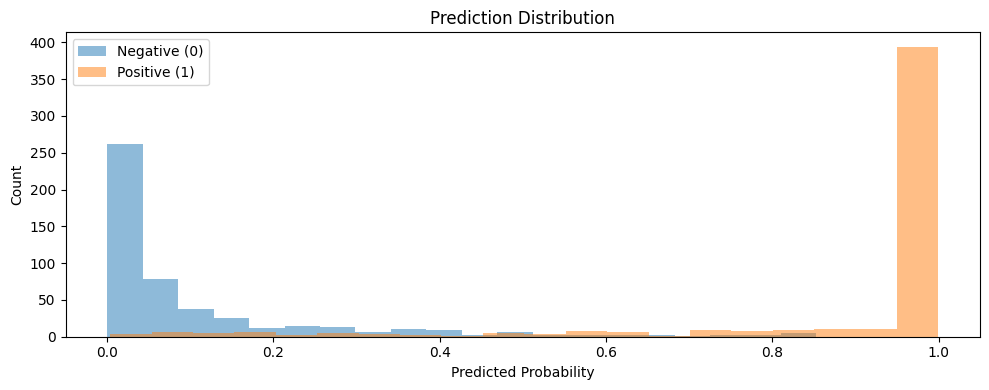

In [4]:
from probe_gen.standard_experiments.experiment_plotting import plot_per_class_prediction_distributions

plot_per_class_prediction_distributions(test_dataset['y'], y_pred_proba)

# Testing On-Off Probes

In [ ]:
from probe_gen.standard_experiments.grid_experiments import run_grid_experiment

run_grid_experiment(
    ['refusal_llama_3b_5k', 'refusal_llama_3b_prompted_5k', "refusal_ministral_8b_5k"], 
    [12, 12, 12], # layer
    [False, False, False], # use_bias   (one for each row)
    [True, True, True], # normalize
    [0.001, 0.001, 0.001], # C
    "llama_3b"
)

### WARNING ###: multiple runs for lookup dict {'config.train_dataset': 'refusal_llama_3b_5k', 'config.test_dataset': 'refusal_llama_3b_5k', 'config.layer': 12, 'config.probe/type': 'mean', 'config.probe/use_bias': False, 'config.probe/normalize': True, 'config.probe/C': 0.001, 'config.activations_model': 'llama_3b', 'state': 'finished'}, returning latest.
refusal_llama_3b_5k, refusal_llama_3b_5k, 0.926336
refusal_llama_3b_5k, refusal_llama_3b_prompted_5k, 0.879856
refusal_llama_3b_5k, refusal_ministral_8b_5k, 0.960144
refusal_llama_3b_prompted_5k, refusal_llama_3b_5k, 0.929368
### WARNING ###: multiple runs for lookup dict {'config.train_dataset': 'refusal_llama_3b_prompted_5k', 'config.test_dataset': 'refusal_llama_3b_prompted_5k', 'config.layer': 12, 'config.probe/type': 'mean', 'config.probe/use_bias': False, 'config.probe/normalize': True, 'config.probe/C': 0.001, 'config.activations_model': 'llama_3b', 'state': 'finished'}, returning latest.
refusal_llama_3b_prompted_5k, refusal_

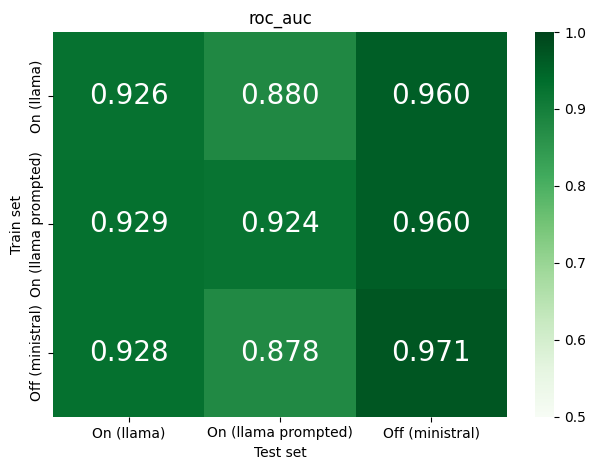

In [7]:
from probe_gen.standard_experiments.grid_experiments import plot_grid_experiment

plot_grid_experiment(
    ['refusal_llama_3b_5k', 'refusal_llama_3b_prompted_5k', "refusal_ministral_8b_5k"],  
    ['On (llama)', 'On (llama prompted)', 'Off (ministral)'],
    [12, 12, 12], # layer
    [False, False, False], # use_bias   (one for each row)
    [True, True, True], # normalize
    [0.001, 0.001, 0.001], # C
    "llama_3b",
    "roc_auc"
)

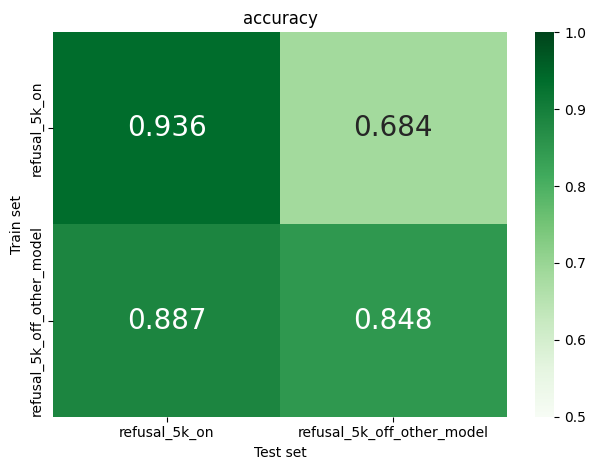

In [2]:
from probe_gen.standard_experiments.experiment_plotting import plot_results_table

plot_results_table(['refusal_5k_on', 'refusal_5k_off_other_model'], 12, 'mean', True, False, 'accuracy')

# Layer experiments

In [1]:
from probe_gen.standard_experiments.layer_experiments import run_layer_experiments

use_bias = True
normalize_inputs = True

run_layer_experiments(
    "mean",
    "lists_llama_3b_story_5k",
    "llama_3b",
    1.0, # C
    [6, 9, 12, 15, 18], 
    use_bias_options=[True, False], 
    normalize_inputs_options=[True, False], 
)

######################### Evaluating layer 6 #############################
Loading from HuggingFace...
Aggregating activations...
Constructing datasets...
Complete.
Training probe...


wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Paste an API key from your profile and hit enter:

Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
######################### Evaluating layer 9 #############################
Loading from HuggingFace...


llama_3b_story_balanced_5k_layer_9.pkl:   0%|          | 0.00/6.61G [00:00<?, ?B/s]

Aggregating activations...
Constructing datasets...
Complete.
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
######################### Evaluating layer 12 #############################
Loading from HuggingFace...


llama_3b_story_balanced_5k_layer_12.pkl:   0%|          | 0.00/6.61G [00:00<?, ?B/s]

Aggregating activations...
Constructing datasets...
Complete.
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
######################### Evaluating layer 15 #############################
Loading from HuggingFace...


llama_3b_story_balanced_5k_layer_15.pkl:   0%|          | 0.00/6.61G [00:00<?, ?B/s]

Aggregating activations...
Constructing datasets...
Complete.
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
######################### Evaluating layer 18 #############################
Loading from HuggingFace...


llama_3b_story_balanced_5k_layer_18.pkl:   0%|          | 0.00/6.61G [00:00<?, ?B/s]

Aggregating activations...
Constructing datasets...
Complete.
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run


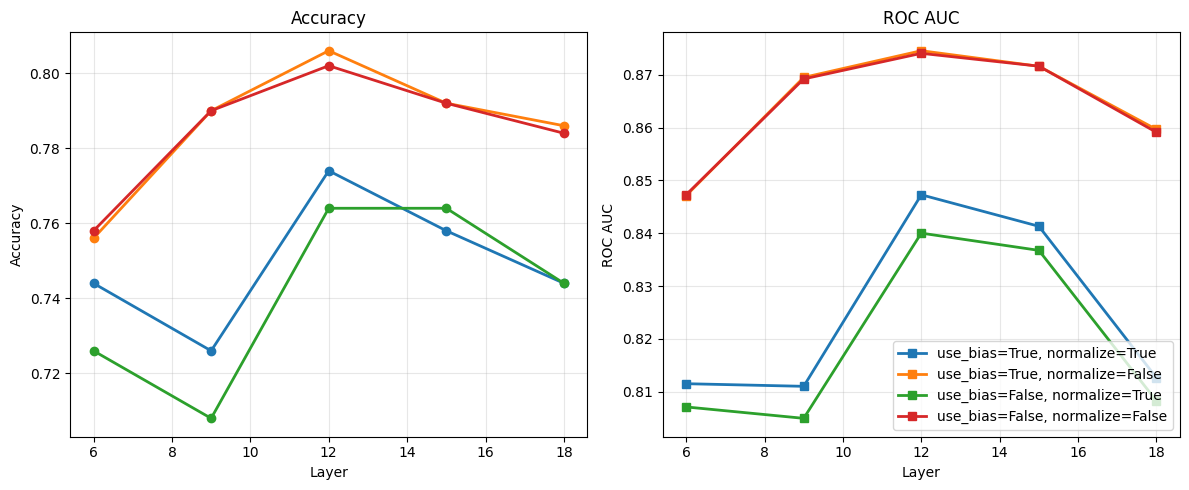

In [2]:
from probe_gen.standard_experiments.experiment_plotting import plot_layer_experiment

plot_layer_experiment([6, 9, 12, 15, 18], 'lists_llama_3b_story_5k')

# Hyperparameter Search

In [3]:
from probe_gen.standard_experiments.hyperparameter_search import run_full_hyp_search_on_layers

# You might not be able to run all layers at once, so can do them in batches like below
run_full_hyp_search_on_layers(
    'mean', 'lists_llama_3b_story_5k', 'llama_3b', [12]
)

######################### Evaluating layer 12 #############################
loading activations (may take ~ 1 minute)
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run
Training probe...
Saved run


In [4]:
from probe_gen.standard_experiments.hyperparameter_search import load_best_params_from_search

load_best_params_from_search(
    'mean', 'lists_llama_3b_story_5k', 'llama_3b', [12]
)

          id                     name     state            created_at  \
0   5dfeo3fe         brisk-shadow-850  finished  2025-08-28T13:58:11Z   
1   irgbb9el      magic-armadillo-851  finished  2025-08-28T13:58:17Z   
2   jfkmeix7       rare-firebrand-852  finished  2025-08-28T13:58:29Z   
3   gwzgqf00          dulcet-fire-856  finished  2025-08-28T13:58:37Z   
4   oplhm32f         lunar-flower-882  finished  2025-08-28T14:02:49Z   
5   mr92ky61          likely-snow-883  finished  2025-08-28T14:02:55Z   
6   soajiuyh      quiet-armadillo-888  finished  2025-08-28T14:03:05Z   
7   5esp3636      twilight-deluge-889  finished  2025-08-28T14:03:16Z   
8   4z8n67ab           drawn-surf-910  finished  2025-08-28T14:07:27Z   
9   jcan51rl          dandy-brook-911  finished  2025-08-28T14:07:32Z   
10  s6pv3dwc   blooming-resonance-912  finished  2025-08-28T14:07:43Z   
11  5ts1yzkb          mild-dragon-913  finished  2025-08-28T14:07:48Z   
12  6tchb3kj       frosty-firefly-954  finished  20

# Compare probe directions

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
import probe_gen.probes as probes
from sklearn.metrics import classification_report
from probe_gen.config import ConfigDict

# dataset_list = ['refusal_llama_3b_5k', 'refusal_llama_3b_prompted_5k', 'refusal_ministral_8b_5k']
# layer_list = [12, 12, 12]
# use_bias_list = [False, False, False]
# normalize_list = [True, True, True]
# C_list = [0.001, 0.001, 0.001]

dataset_list = ['lists_llama_3b_5k', 'lists_llama_3b_prompted_5k', 'lists_qwen_3b_5k']
layer_list = [9, 12, 12]
use_bias_list = [True, True, False]
normalize_list = [False, False, False]
C_list = [1, 10, 1]

# dataset_list = ['metaphors_llama_3b_5k', 'metaphors_llama_3b_prompted_5k', 'metaphors_qwen_3b_5k']
# layer_list = [9, 15, 6]
# use_bias_list = [False, False, True]
# normalize_list = [False, False, False]
# C_list = [1, 1, 1]

probes_list = []

for i in range(len(dataset_list)):
    activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer(dataset_list[i], layer_list[i], verbose=True)
    activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
    # Create train, val, and test datasets
    train_dataset, val_dataset, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0.1, test_size=0.2, verbose=True)

    probe = probes.SklearnLogisticProbe(ConfigDict(use_bias=use_bias_list[i], C=C_list[i], normalize=normalize_list[i]))
    probe.fit(train_dataset, val_dataset)
    probes_list.append(probe)

loaded labels


llama_3b_balanced_5k_layer_9.pkl:   0%|          | 0.00/4.82G [00:00<?, ?B/s]

loaded activations with shape torch.Size([5000, 257, 3072])
calculated attention mask with shape torch.Size([5000, 257])
Train: 3500 samples, 1750.0 positives
Val:   500 samples, 250.0 positives
Test:  1000 samples, 500.0 positives
Training probe...
loaded labels
loaded activations with shape torch.Size([5000, 257, 3072])
calculated attention mask with shape torch.Size([5000, 257])
Train: 3500 samples, 1750.0 positives
Val:   500 samples, 250.0 positives
Test:  1000 samples, 500.0 positives
Training probe...
loaded labels
loaded activations with shape torch.Size([5000, 253, 3072])
calculated attention mask with shape torch.Size([5000, 253])
Train: 3500 samples, 1750.0 positives
Val:   500 samples, 250.0 positives
Test:  1000 samples, 500.0 positives
Training probe...


In [15]:
weights = []
biases = []
for i in range(len(probes_list)):
    weights.append(probes_list[i].classifier.coef_.flatten())
    biases.append(probes_list[i].classifier.intercept_.flatten())

print(biases)

print(cosine_similarity([weights[0]], [weights[1]])[0, 0])
print(cosine_similarity([weights[0]], [weights[2]])[0, 0])
print(cosine_similarity([weights[1]], [weights[2]])[0, 0])

[array([0.]), array([0.]), array([-1.64785788])]
0.2301485257997929
0.34548292652160034
0.1924166061016448


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
import probe_gen.probes as probes
from sklearn.metrics import classification_report
from probe_gen.config import ConfigDict

weights_list = []
for i in range(5):
    activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer("refusal_llama_3b_5k", 12, verbose=True)
    activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
    # Create train, val, and test datasets
    train_dataset, val_dataset, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0.1, test_size=0.2, balance=True, verbose=True)

    probe = probes.SklearnLogisticProbe(ConfigDict(use_bias=False, C=0.001, normalize=True))
    probe.fit(train_dataset, val_dataset)
    weights = probe.classifier.coef_
    weights_list.append(weights)

loaded labels
loaded activations with shape torch.Size([5000, 337, 3072])
calculated attention mask with shape torch.Size([5000, 337])
Train: 3500 samples, 1750.0 positives
Val:   500 samples, 250.0 positives
Test:  1000 samples, 500.0 positives
Training probe...
loaded labels
loaded activations with shape torch.Size([5000, 337, 3072])
calculated attention mask with shape torch.Size([5000, 337])
Train: 3500 samples, 1750.0 positives
Val:   500 samples, 250.0 positives
Test:  1000 samples, 500.0 positives
Training probe...
loaded labels
loaded activations with shape torch.Size([5000, 337, 3072])
calculated attention mask with shape torch.Size([5000, 337])
Train: 3500 samples, 1750.0 positives
Val:   500 samples, 250.0 positives
Test:  1000 samples, 500.0 positives
Training probe...
loaded labels
loaded activations with shape torch.Size([5000, 337, 3072])
calculated attention mask with shape torch.Size([5000, 337])
Train: 3500 samples, 1750.0 positives
Val:   500 samples, 250.0 positives

In [5]:
weights = np.concatenate(weights_list, axis=0)
print(weights.var(axis=0))

[7.52316385e-37 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


# OLD CODE

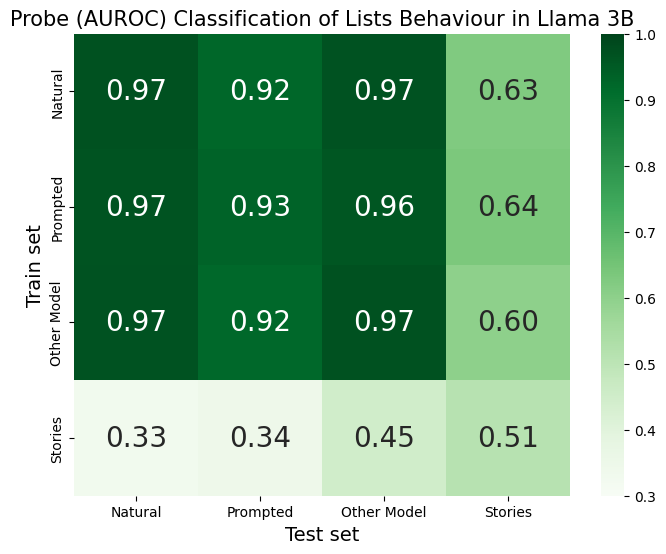

In [16]:
# Generate fake graph
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Create the heatmap with seaborn
sns.heatmap(
    [[0.97,0.924,0.969,0.626], [0.966,0.932,0.96,0.635], [0.968,0.922,0.97,0.6], [0.33,0.345,0.449,0.511]], 
    xticklabels=['Natural', 'Prompted', 'Other Model', 'Stories'],
    yticklabels=['Natural', 'Prompted', 'Other Model', 'Stories'],
    annot=True,  # This adds the text annotations
    fmt='.2f',   # Format numbers to 3 decimal places
    cmap='Greens',  # You can change the colormap
    vmin=0.3,
    vmax=1,
    ax=ax,
    annot_kws={"size": 20}
)

# Rotate x-axis labels
#plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

# Set labels and title
plt.xlabel('Test set', fontsize=14)
plt.ylabel('Train set', fontsize=14)
ax.set_title("Probe (AUROC) Classification of Lists Behaviour in Llama 3B", fontsize=15)

# increase graph size
fig.set_size_inches(8, 6)
# fig.tight_layout()
plt.show()


In [ ]:
import probe_gen.probes as probes
from sklearn.metrics import classification_report


activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer("refusal_5k_on", 12, verbose=True)
activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
# Create train, val, and test datasets
train_dataset, val_dataset, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0, test_size=0.2, balance=True, verbose=True)


In [ ]:
from probe_gen.config import ConfigDict

C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10]
evals_norm_true_bias_true = []
evals_norm_true_bias_false = []
evals_norm_false_bias_true = []
evals_norm_false_bias_false = []

for C in C_values:
    print(f"############ {C} #############")

    probe = probes.SklearnLogisticProbe(ConfigDict(use_bias=True, C=C, normalize=True))
    probe.fit(train_dataset, val_dataset)
    eval_dict, _, _ = probe.eval(test_dataset)
    evals_norm_true_bias_true.append(eval_dict)

    probe = probes.SklearnLogisticProbe(ConfigDict(use_bias=False, C=C, normalize=True))
    probe.fit(train_dataset, val_dataset)
    eval_dict, _, _ = probe.eval(test_dataset)
    evals_norm_true_bias_false.append(eval_dict)

    probe = probes.SklearnLogisticProbe(ConfigDict(use_bias=True, C=C, normalize=False))
    probe.fit(train_dataset, val_dataset)
    eval_dict, _, _ = probe.eval(test_dataset)
    evals_norm_false_bias_true.append(eval_dict)

    probe = probes.SklearnLogisticProbe(ConfigDict(use_bias=False, C=C, normalize=False))
    probe.fit(train_dataset, val_dataset)
    eval_dict, _, _ = probe.eval(test_dataset)
    evals_norm_false_bias_false.append(eval_dict)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract accuracy and ROC-AUC values for each configuration
def extract_metrics(results_list):
    accuracy = [result['accuracy'] for result in results_list]
    roc_auc = [result['roc_auc'] for result in results_list]
    return accuracy, roc_auc

# Extract metrics for all configurations
acc1, roc1 = extract_metrics(evals_norm_true_bias_true)
acc2, roc2 = extract_metrics(evals_norm_true_bias_false)
acc3, roc3 = extract_metrics(evals_norm_false_bias_true)
acc4, roc4 = extract_metrics(evals_norm_false_bias_false)

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Define labels for each configuration (modify these based on your actual hyperparameter combinations)
config_labels = [
    'normalize=True, use_bias=True',  # Replace with actual hyperparameter values, e.g., 'penalty=l2, solver=lbfgs'
    'normalize=True, use_bias=False',  # e.g., 'penalty=l2, solver=liblinear'
    'normalize=False, use_bias=True',  # e.g., 'penalty=l1, solver=liblinear'
    'normalize=False, use_bias=False'   # e.g., 'penalty=elasticnet, solver=saga'
]

# Plot accuracy (left subplot)
ax1.semilogx(C_values, acc1, marker='o', label=config_labels[0])
ax1.semilogx(C_values, acc2, marker='s', label=config_labels[1])
ax1.semilogx(C_values, acc3, marker='^', label=config_labels[2])
ax1.semilogx(C_values, acc4, marker='d', label=config_labels[3])

ax1.set_xlabel('C (Inverse Regularization Strength)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs C')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot ROC-AUC (right subplot)
ax2.semilogx(C_values, roc1, marker='o', label=config_labels[0])
ax2.semilogx(C_values, roc2, marker='s', label=config_labels[1])
ax2.semilogx(C_values, roc3, marker='^', label=config_labels[2])
ax2.semilogx(C_values, roc4, marker='d', label=config_labels[3])

ax2.set_xlabel('C (Inverse Regularization Strength)')
ax2.set_ylabel('ROC-AUC')
ax2.set_title('ROC-AUC vs C')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

# Optional: Find and print the best configuration for each metric
def find_best_config(metric_lists, config_labels, C_values):
    best_scores = []
    for i, metrics in enumerate(metric_lists):
        best_idx = np.argmax(metrics)
        best_scores.append({
            'config': config_labels[i],
            'best_C': C_values[best_idx],
            'best_score': metrics[best_idx]
        })
    return best_scores

# Find best configurations
accuracy_lists = [acc1, acc2, acc3, acc4]
roc_lists = [roc1, roc2, roc3, roc4]

print("Best Accuracy Results:")
best_acc = find_best_config(accuracy_lists, config_labels, C_values)
for result in best_acc:
    print(f"{result['config']}: C={result['best_C']}, Accuracy={result['best_score']:.4f}")

print("\nBest ROC-AUC Results:")
best_roc = find_best_config(roc_lists, config_labels, C_values)
for result in best_roc:
    print(f"{result['config']}: C={result['best_C']}, ROC-AUC={result['best_score']:.4f}")